# 🧪 Explorador Interactivo de Planes de Estudio

Este notebook te permite modificar parámetros como el objetivo del estudiante, los valores de `n` y `m`, y visualizar el plan generado con su fitness.

👇 Sigue las instrucciones en cada celda.

In [46]:
# 📦 1. Cargar módulos y configurar entorno
import sys, os, json, random
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(".."))

from src.models import StudentProfile, KnowledgeGraph
from src.algorithm import generate_random_plan, crossover, mutate
from src.evaluation import calculate_fitness, is_valid_plan

In [47]:
# 🧠 2. Cargar perfil del estudiante y objetivos disponibles
with open('../data/student_profile.json') as f:
    student_data = json.load(f)

with open('../data/objectives.json') as f:
    objectives = json.load(f)

print("Objetivos disponibles:")
for key in objectives:
    print("-", key)

Objetivos disponibles:
- backend_dev
- frontend_dev
- data_scientist
- seguridad


In [48]:
# 🎯 3. Cambiar objetivo del estudiante aquí 👇

 # Cambia aquí: data_scientist, backend_dev, frontend_dev, seguridad

student = StudentProfile(**student_data)
print(student_data['goal'])

data_scientist


In [49]:
# 📚 4. Cargar grafo de conocimiento
with open('../data/knowledge_graph_expandido.json') as f:
    graph_data = json.load(f)
graph = KnowledgeGraph(graph_data)


In [ ]:
# ⚙️ 5. Ajustar parámetros del plan (n = temas, m = subtemas por tema)
n = 3
m = 1



In [ ]:
# 🤖 6. Ejecutar algoritmo genético y mostrar plan
from src.models import StudyPlan

def genetic_optimize_trace(student, graph, n, m, pop_size=1000, generations=30):
    fitness_history = []
    population = [generate_random_plan(graph, student, n, m) for _ in range(pop_size)]
    best_plan = None
    best_fitness = float('-inf')
    for gen in range(generations):
        scored = [(p, calculate_fitness(p, student, graph, {'alpha': 0.5558909602765315, 'beta': 0.04660247200567484, 'gamma': 0.39390366241184177, 'delta': 0.003602905305951746})) for p in population if is_valid_plan(p, student, graph, n, m)]
        scored.sort(key=lambda x: x[1], reverse=True)
        fitness_history.append([x[1] for x in scored])
        if not scored:
            break
        if scored[0][1] > best_fitness:
            best_fitness = scored[0][1]
            best_plan = scored[0][0]
        parents = [x[0] for x in scored]
        if len(parents) < 2:
            parents *= 2
        children = []
        while len(children) < pop_size:
            i1 = random.randint(0, len(parents) - 1)
            i2 = random.randint(0, len(parents) - 1)
            child = crossover(parents[i1], parents[i2])
            if random.random() < 0.1:
                child = mutate(child, graph, student, m)
            children.append(child)
        population = children
    return best_plan, best_fitness, fitness_history

# Ejecutar
plan, score, history = genetic_optimize_trace(student, graph, n=n, m=m)

if plan is None:
    print("⚠ No se encontró ningún plan válido.")
else:
    print("\n📘 Mejor plan encontrado:")
    for tema in plan.topics():
        print(f"- {tema}: {plan.subtopics(tema)}")
    print("\n📚 Subtemas totales:", plan.all_subtopics())
    print("🎯 Fitness final:", score)



📘 Mejor plan encontrado:
- Inteligencia Artificial: ['Redes Neuronales']
- Algoritmos: ['Estructuras de Datos']
- Matemáticas Discretas: ['Estadística']

📚 Subtemas totales: ['Redes Neuronales', 'Estructuras de Datos', 'Estadística']
🎯 Fitness final: 0.8099999999999999


In [52]:
from src.models import StudyPlan

plan = StudyPlan({})  # plan vacío inicial

for topic in student.goal_required_topics():
    subs = graph.get_subtopics(topic)
    posibles = []
    for s in subs:
        if student.knowledge.get(s, 0) >= 0.4:
            continue
        if all(
            student.knowledge.get(p, 0) >= 0.6 or p in plan.all_subtopics()
            for p in graph.prerequisites(s)
        ):
            posibles.append(s)
    print(f"{topic}: {len(posibles)} subtemas válidos → {posibles}")


Matemáticas Discretas: 3 subtemas válidos → ['Estadística', 'Probabilidad', 'Teoría de Grafos']
Algoritmos: 3 subtemas válidos → ['Estructuras de Datos', 'Algoritmos de Búsqueda', 'Recursión']
Inteligencia Artificial: 1 subtemas válidos → ['Agentes Inteligentes']


In [53]:
for topic in student.goal_required_topics():
    all_subs = graph.get_subtopics(topic)
    valid_subs = [s for s in all_subs if student.knowledge.get(topic, 0) < 0.4]
    print(f"{topic}: {len(valid_subs)} subtemas válidos")


Matemáticas Discretas: 0 subtemas válidos
Algoritmos: 0 subtemas válidos
Inteligencia Artificial: 3 subtemas válidos


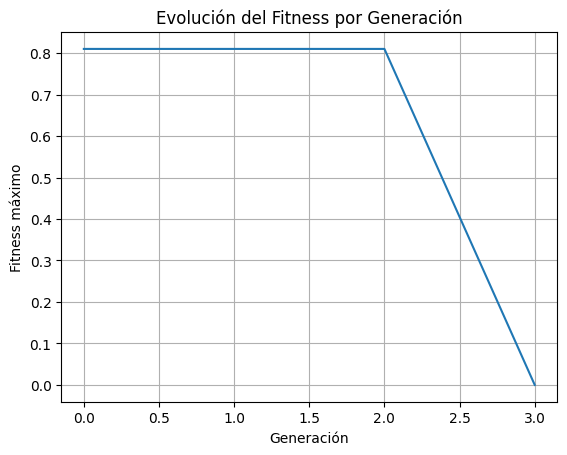

In [54]:
# 📈 7. Visualizar evolución del fitness
if history:
    max_per_gen = [max(g) if g else 0 for g in history]
    plt.plot(max_per_gen)
    plt.title("Evolución del Fitness por Generación")
    plt.xlabel("Generación")
    plt.ylabel("Fitness máximo")
    plt.grid(True)
    plt.show()